# <center> University of Liverpool - Ion Switching </centrer>
## <center> Identify the number of channels open at each time point </centrer>

## План


1 Описание задачи 

2 Генерация признаков

    2.1 Лаговые признаки
    
    2.2 Статистические признаки с переменной шириной окна
    
3 Выбор метрики и целевой функции

    3.1 multiclass logloss
    
    3.2 RMSE
    
    3.3 Собственные метрики
    
4 Модели

    4.1 Градиентный бустинг (LightGBM)
    
    4.2 Rapids KNN
    
    4.3 WaveNet
    
5 Сравение моделей

6 Удаление дрифта в сигнале


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# <center> Описание задачи

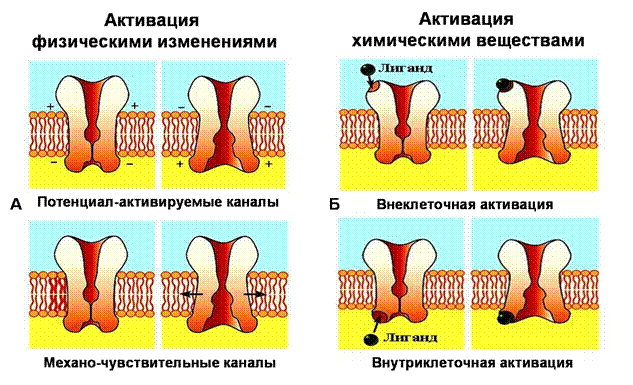


Считается, что многие заболевания, включая рак, имеют общий фактор. Ионные каналы представляют собой порообразующие белки, присутствующие у животных и растений. Они кодируют обучение и память, помогают бороться с инфекциями, дают болевые сигналы и стимулируют сокращение мышц. Если бы ученые могли лучше изучать ионные каналы, что возможно с помощью машинного обучения, это могло бы иметь далеко идущие последствия.



Когда ионные каналы открываются, они пропускают электрические токи. Существующие методы обнаружения этих изменений состояния медленные и трудоемкие. Люди должны контролировать анализ, который придает значительный уклон, в дополнение к утомительным. Эти трудности ограничивают объем анализа тока ионного канала, который можно использовать в исследованиях. Ученые надеются, что технология может обеспечить быстрое автоматическое обнаружение текущих событий ионного канала в необработанных данных.

Институт старения и хронических заболеваний Ливерпульского университета работает над продвижением исследований ионных каналов. Их команда ученых обратилась за вашей помощью. В этом конкурсе вы будете использовать данные ионных каналов для улучшения моделей автоматической идентификации. В случае успеха вы сможете обнаружить отдельные события ионных каналов в зашумленных необработанных сигналах. Данные моделируются и вводятся с шумом реального мира, чтобы подражать тому, что ученые наблюдают в лабораторных экспериментах.

Технология анализа электрических данных в элементах за последние 20 лет существенно не изменилась. Если мы лучше поймем активность ионных каналов, исследование может повлиять на многие области, связанные со здоровьем и миграцией клеток. От болезней человека до влияния изменения климата на растения, более быстрое обнаружение ионных каналов может значительно ускорить решение основных мировых проблем.

## Метрика

$$ F_1 = 2\frac{precision * recall}{precision + recall}  \\ \\ 
precision = \frac{TP}{TP + FP} \\ \\
recall = \frac{TP}{TP + FN}$$

Метрика "macro" F1 считается по каждому числу ионных каналов и усредняется.

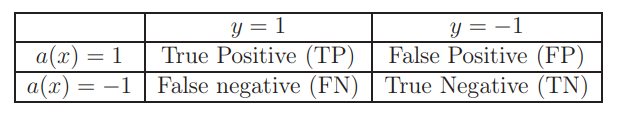

Решение оценивается по данной метрике.

## Обработка данных

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [3]:
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [4]:
test.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


In [5]:
train.shape, test.shape

((5000000, 3), (2000000, 2))

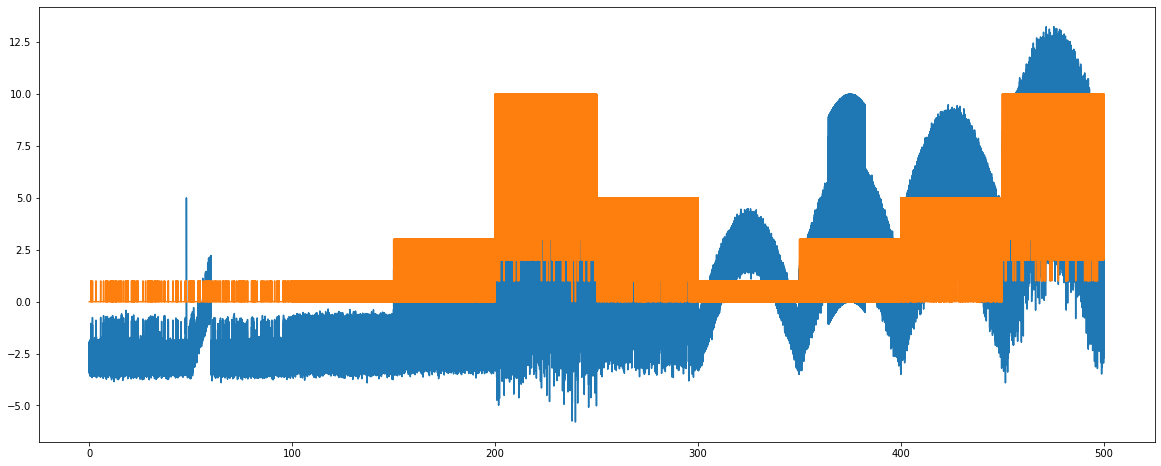

In [5]:
plt.figure(figsize=(20, 8))
plt.plot(train.time, train.signal)
plt.plot(train.time, train.open_channels)
plt.show()

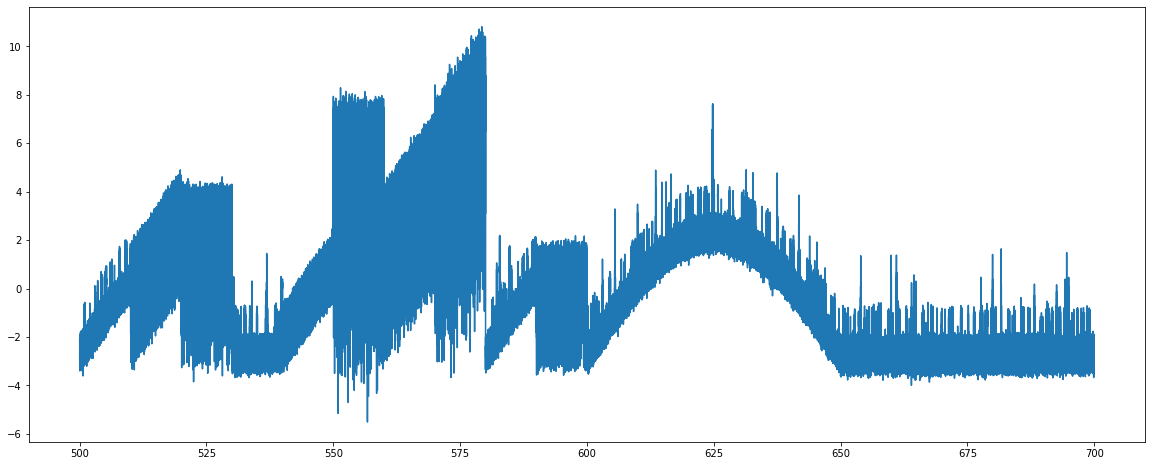

In [4]:
plt.figure(figsize=(20,8))
plt.plot(test.time, test.signal)
plt.show()

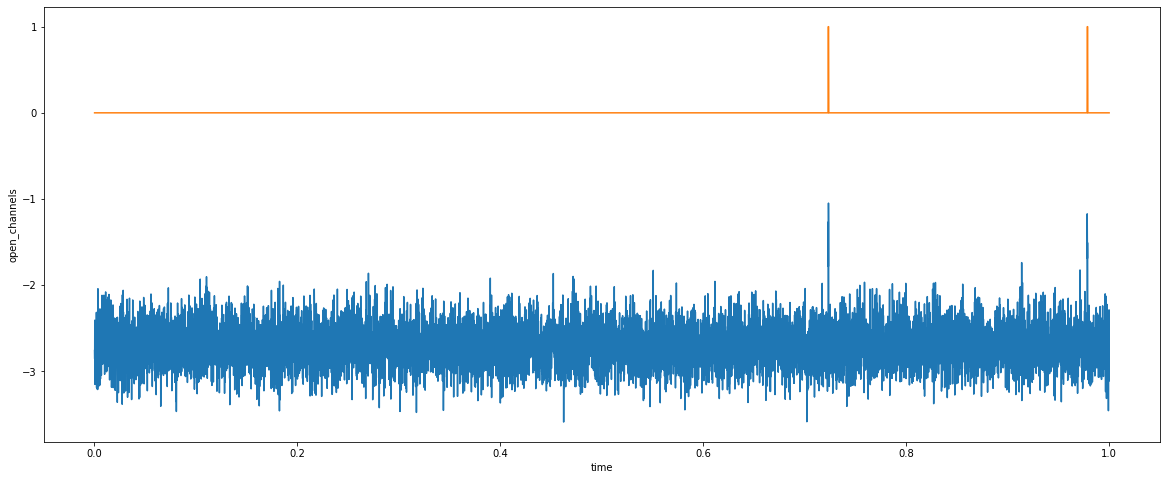

In [3]:
plt.figure(figsize=(20,8))
sns.lineplot(train.time[:10000], train.signal[:10000])
sns.lineplot(train.time[:10000], train.open_channels[:10000])
plt.show()

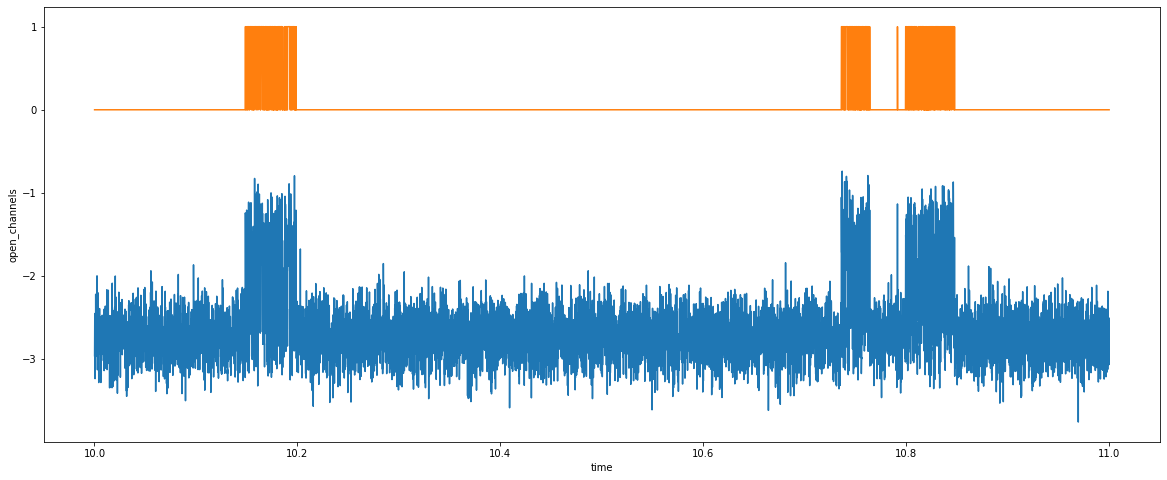

In [6]:
plt.figure(figsize=(20,8))
sns.lineplot(train.time[100000:110000], train.signal[100000:110000])
sns.lineplot(train.time[100000:110000], train.open_channels[100000:110000])
plt.show()

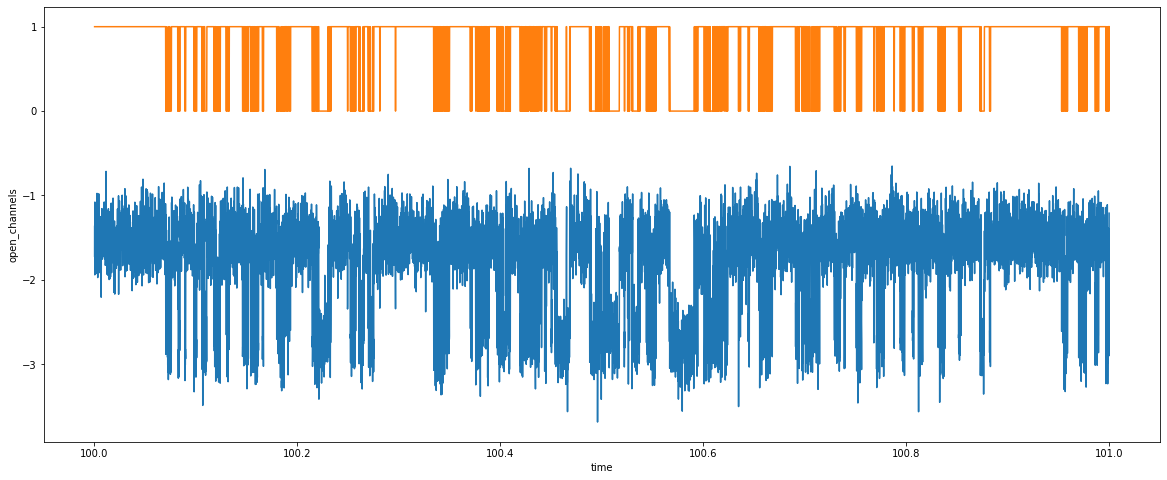

In [7]:
plt.figure(figsize=(20,8))
sns.lineplot(train.time[1000000:1010000], train.signal[1000000:1010000])
sns.lineplot(train.time[1000000:1010000], train.open_channels[1000000:1010000])
plt.show()

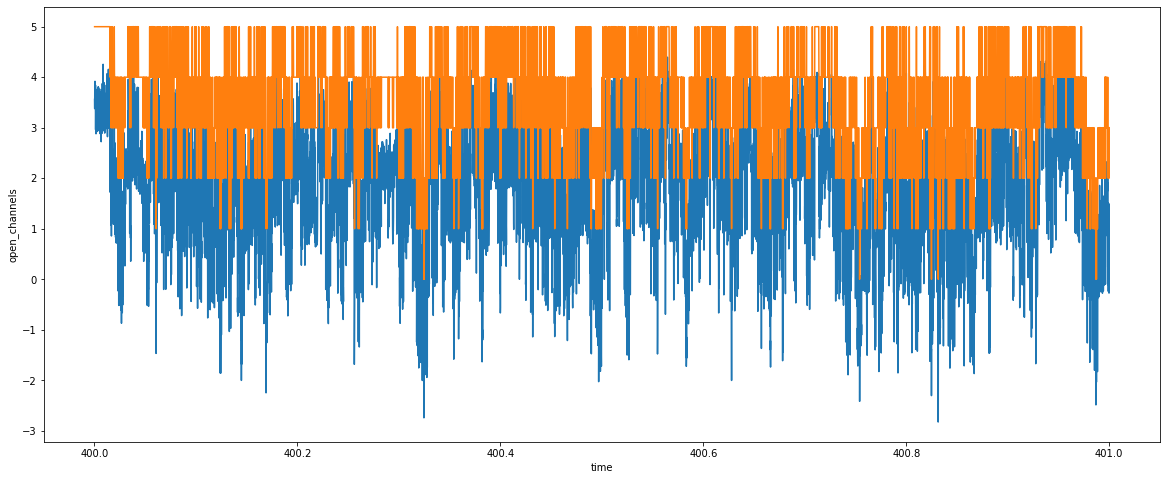

In [8]:
plt.figure(figsize=(20,8))
sns.lineplot(train.time[4000000:4010000], train.signal[4000000:4010000])
sns.lineplot(train.time[4000000:4010000], train.open_channels[4000000:4010000])
plt.show()

In [9]:
train.open_channels.value_counts()

0     1240152
1      985865
3      668609
2      553924
4      403410
5      277877
7      265015
8      245183
6      188112
9      136120
10      35733
Name: open_channels, dtype: int64

# <center>  Генерация признаков

Будем решать задачу регрессии.

Нам дан только один признак - сигнал. Очевидо, что этого недостаточно, однако сигнал и число ионных каналов - временные ряды. 

Внешние факторы определить невозможно, поэтому будем выделять признаки из временного ряда.

<h2> Виды признаков </h2>


1. Лаговые признаки  - получчаются в результате сдвига на несколько наблюдений временного ряда вперед или назад. 


2. Статистические признаки - такие признаки, как среднее, медина, скользящее среднее.

Такой объем данных не вмещается в оперативную память моего ноутбука, поэтому для приимера рассмотрим последние 500000 наблюдений.

In [2]:
train = pd.read_csv('data/train_tail.csv')
test = pd.read_csv('data/test.csv')
train = train.drop(columns = ['Unnamed: 0'])

## Нормализация

In [3]:
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test

## Гиперпараметры

In [4]:
NNBATCHSIZE = 16
GROUP_BATCH_SIZE = 4000
SEED = 321
LR = 0.0015
SPLITS = 6

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [5]:
def batching(df, batch_size):
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df

## Лаговые признаки

In [6]:
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df

def run_feat_engineering(df, batch_size):
    df = batching(df, batch_size = batch_size)
    df = lag_with_pct_change(df, [1, 2, 3])
    df['signal_2'] = df['signal'] ** 2
    return df

def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index', 'group', 'open_channels', 'time']]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features

In [7]:
train, test = normalize(train, test)

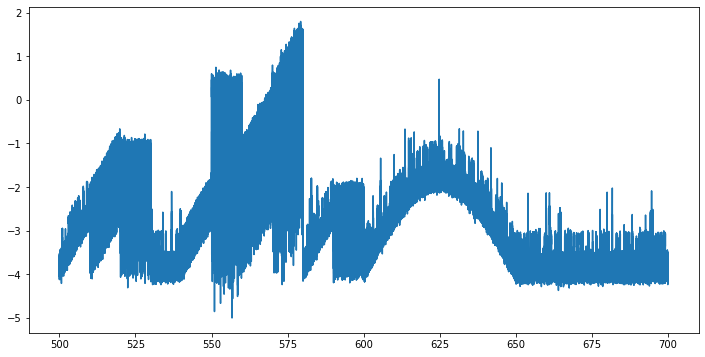

In [10]:
plt.figure(figsize=(12,6))
plt.plot(test.time, test.signal)
plt.show()

In [11]:
train = run_feat_engineering(train, batch_size = GROUP_BATCH_SIZE)
test = run_feat_engineering(test, batch_size = GROUP_BATCH_SIZE)
train, test, features = feature_selection(train, test)

In [12]:
features

['signal',
 'signal_shift_pos_1',
 'signal_shift_neg_1',
 'signal_shift_pos_2',
 'signal_shift_neg_2',
 'signal_shift_pos_3',
 'signal_shift_neg_3',
 'signal_2']

In [13]:
train.shape, test.shape

((500000, 11), (2000000, 10))

## Статистические признаки

Будем считать моменты для разного размера окон.

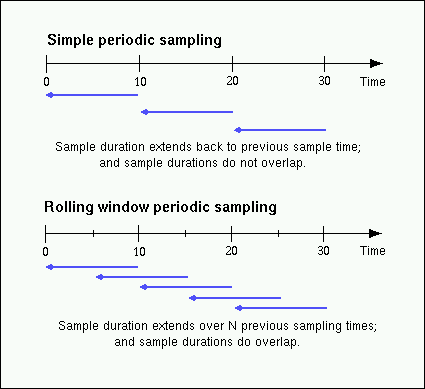

In [14]:
train['signal_rolling_mean_1h'] = train['signal'].rolling(window = 100).mean().fillna(0)
test['signal_rolling_mean_1h'] = test['signal'].rolling(window = 100).mean().fillna(0)

train['signal_rolling_std_1h'] = train['signal'].rolling(window = 100).std().fillna(0)
test['signal_rolling_std_1h'] = test['signal'].rolling(window = 100).std().fillna(0)

train['signal_rolling_median_1h'] = train['signal'].rolling(window = 100).median().fillna(0)
test['signal_rolling_median_1h'] = test['signal'].rolling(window = 100).median().fillna(0)

train['signal_rolling_mean_1t'] = train['signal'].rolling(window = 1000).mean().fillna(0)
test['signal_rolling_mean_1t'] = test['signal'].rolling(window = 1000).mean().fillna(0)

train['signal_rolling_std_1t'] = train['signal'].rolling(window = 1000).std().fillna(0)
test['signal_rolling_std_1t'] = test['signal'].rolling(window = 1000).std().fillna(0)

train['signal_rolling_median_1t'] = train['signal'].rolling(window = 1000).median().fillna(0)
test['signal_rolling_median_1t'] = test['signal'].rolling(window = 1000).median().fillna(0)

train['shift_100'] = train['signal'].shift(100)
train['shift_1000'] = train['signal'].shift(1000)

test['shift_100'] = test['signal'].shift(100)
test['shift_1000'] = test['signal'].shift(1000)

In [15]:
train.shape, test.shape

((500000, 19), (2000000, 18))

In [28]:
list(train.columns)

['time',
 'signal',
 'open_channels',
 'group',
 'signal_shift_pos_1',
 'signal_shift_neg_1',
 'signal_shift_pos_2',
 'signal_shift_neg_2',
 'signal_shift_pos_3',
 'signal_shift_neg_3',
 'signal_2',
 'signal_rolling_mean_1h',
 'signal_rolling_std_1h',
 'signal_rolling_median_1h',
 'signal_rolling_mean_1t',
 'signal_rolling_std_1t',
 'signal_rolling_median_1t',
 'shift_100',
 'shift_1000']

# <center> Выбор метрики

Метрика multiclass logloss:

$$ logloss(a, y) =  \sum_{i=1}^{N} -y_i \log(a_i) - (1 - y_i)\log(1 - a_i) \to min $$

Метрика RMSE:

$$ RMSE(a, y) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (a - y)^2} \to min$$

Хотим сделать больший вес последним наблюдениям.

$$ y,\hat{y} \in \{0, \dots, 10\} \\ $$
$$ Loss_1(y, \hat{y}) = - \frac{1}{n} \sum_{i=0}^{n} (y_i = \hat{y}_i ) (y_i + 1) \\ $$
$$ Loss_2(y, \hat{y}) = - \sum_{k=0}^{10} (k + 1) f_1(y, \hat{y}) |\quad  y = k \\ $$

$$ Loss_3(y, \hat{y}) = \sum_{i = 1}^{shape} (y_i != \hat{y_i})  i $$

# <center> Модели

## LightGBM

In [16]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X = train.drop(['time', 'open_channels'], axis = 1)
y = train['open_channels']
X_test = test.drop(['time'], axis = 1)

X_train, X_val, y_train, y_val = train_test_split(X, y)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

lgbm_params = {
    'objective': 'multiclass',
    'num_class': 11}

model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval)
#y_pred = model.predict(X_test, num_iteration=model.best_iteration)
#y_pred_max = np.argmax(y_pred, axis=1)

[1]	valid_0's multi_logloss: 1.58038
[2]	valid_0's multi_logloss: 1.45349
[3]	valid_0's multi_logloss: 1.36341
[4]	valid_0's multi_logloss: 1.28011
[5]	valid_0's multi_logloss: 1.21015
[6]	valid_0's multi_logloss: 1.14516
[7]	valid_0's multi_logloss: 1.092
[8]	valid_0's multi_logloss: 1.04387
[9]	valid_0's multi_logloss: 0.998558
[10]	valid_0's multi_logloss: 0.963931
[11]	valid_0's multi_logloss: 0.924138
[12]	valid_0's multi_logloss: 0.881836
[13]	valid_0's multi_logloss: 0.858455
[14]	valid_0's multi_logloss: 0.824814
[15]	valid_0's multi_logloss: 0.800628
[16]	valid_0's multi_logloss: 0.774062
[17]	valid_0's multi_logloss: 0.747521
[18]	valid_0's multi_logloss: 0.734882
[19]	valid_0's multi_logloss: 0.709975
[20]	valid_0's multi_logloss: 0.706032
[21]	valid_0's multi_logloss: 0.678427
[22]	valid_0's multi_logloss: 0.656527
[23]	valid_0's multi_logloss: 0.685385
[24]	valid_0's multi_logloss: 0.631481
[25]	valid_0's multi_logloss: 0.625241
[26]	valid_0's multi_logloss: 0.606032
[27]	

## Значимость признаков

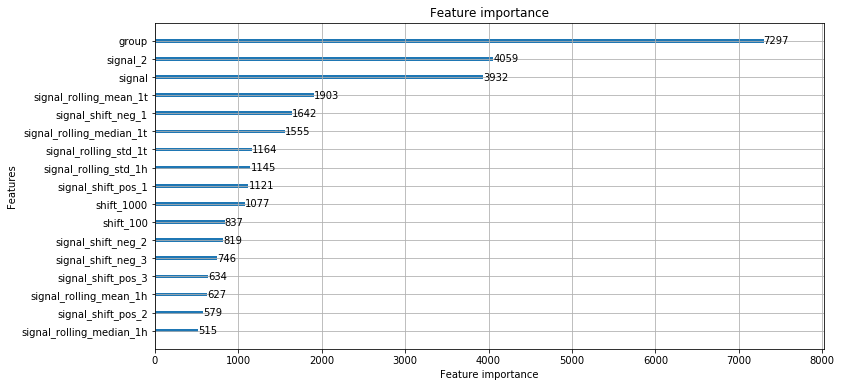

In [21]:
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

## Результат

In [12]:
from sklearn.metrics import f1_score

y_pred_max_train = np.argmax(model.predict(X, num_iteration=model.best_iteration), axis=1)
f1_score(y_pred_max_train, y, average='macro')

0.7233303719755906

In [11]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

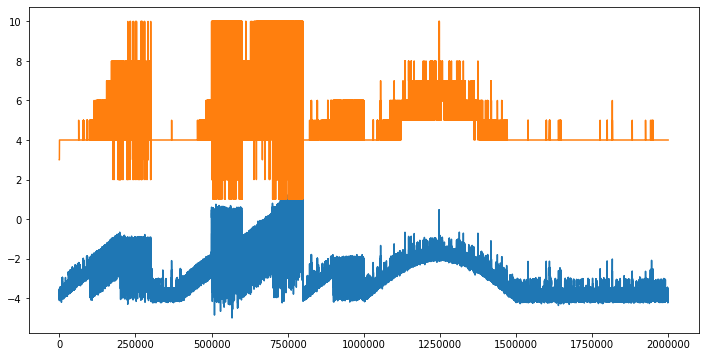

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(X_test.signal)
plt.plot(y_pred_max)
plt.show()

## Арихтектура WaveNet

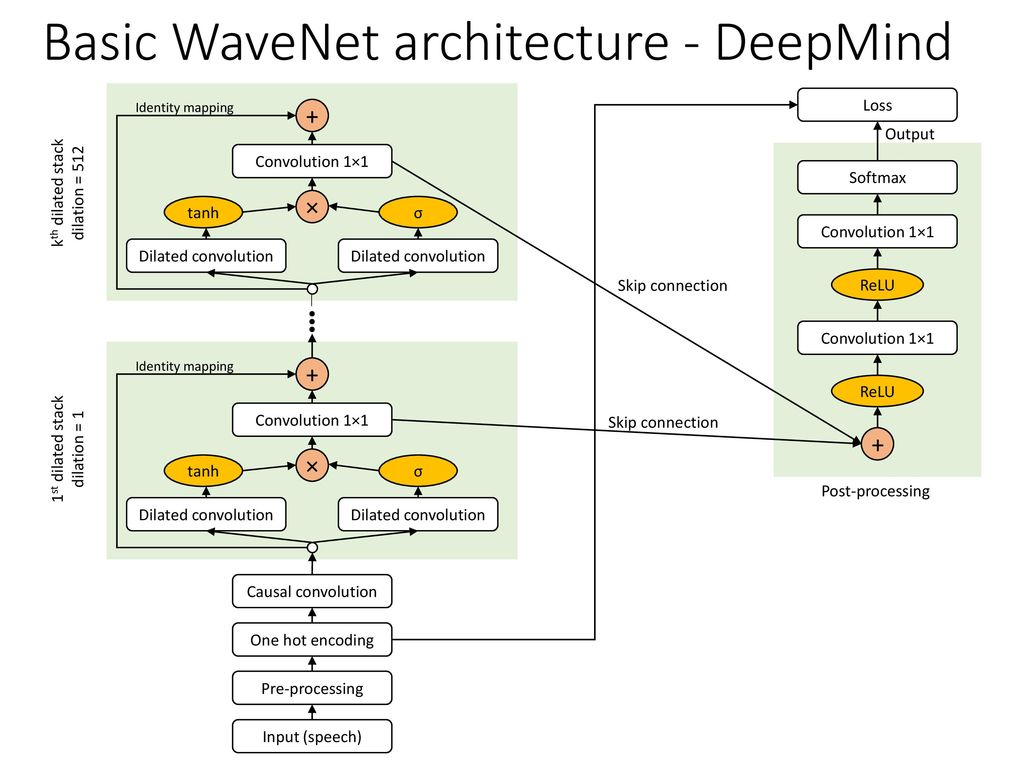

In [10]:
def Classifier(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss = losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

## Результаты и сравнение моделей

In [29]:
res_wavenet = pd.read_csv('res/submission_wavenet (1).csv')
res_lgbm = pd.read_csv('res/submission_wavenet_lgbm1.csv')
res_knn = pd.read_csv('res/submission.csv')

In [31]:
df = pd.DataFrame({'res_wavenet': res_wavenet.open_channels, 'res_lgbm': res_lgbm.open_channels, 'res_knn': res_knn.open_channels})

In [33]:
df.corr()

,res_wavenet,res_lgbm,res_knn
res_wavenet,1.000000,0.998523,0.998218
res_lgbm,0.998523,1.000000,0.999201
res_knn,0.998218,0.999201,1.000000


## Удаление дрифта